In [23]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter

from fourier_scale_calibration import FourierSpaceCalibrator, windowed_fft
from fourier_scale_calibration.structures import make_graphene, make_amourphous_contamination
from fourier_scale_calibration.simulate import simulate_2d_material, probe_profile

def is_close(a, b, tol):
    return np.abs(a - b) < tol

def hexagonal_pixel_accuracy(shape, lattice_constant):
    return 1 / (min(shape) / lattice_constant * 2 / np.sqrt(3))

np.random.seed(0)

## Usage

The `FourierSpaceCalibrator` object searches for a user-defined template in fourier-space by scanning through all rotations and scales.

* `template` : the template to search for
* `lattice_constant` : the lattice constant consistent with the template in Angstrom
* `min_sampling` : the minimum pixel size to search for. This is optional, but may improve robustness.
* `max_sampling` : the maximum pixel size to search for
* `normalize_azimuthal` : set this to false if the noise is low

We create a simulated image with a sampling of 0.05 Angstrom / pixel and detect this sampling.

In [24]:
atoms = make_graphene((50,50))

image = simulate_2d_material(atoms, probe_profile(1.5, 1.4, .5), sampling=.05)
noisy_image = np.random.poisson(image * .005).astype(np.float32)

true sampling 0.05 detected sampling 0.05047802737288466


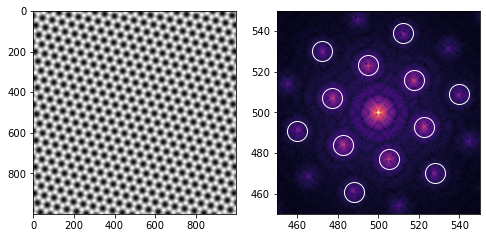

In [26]:
calibrator = FourierSpaceCalibrator('2nd-order-hexagonal', 
                                    lattice_constant=2.46, max_sampling=.2, min_sampling=.01,
                                    normalize_azimuthal=False)
f = np.abs(np.fft.fftshift(windowed_fft(image)))

calibrator.calibrate(image)

spots = calibrator.get_spots()

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,8))
ax1.imshow(gaussian_filter(image,2),cmap='gray')
ax2.imshow(f ** .2,cmap='magma')
ax2.plot(*spots.T,'wo', mfc='none', markersize=20)

n = 50
ax2.set_xlim(f.shape[0] // 2 - n, f.shape[0] // 2 + n)
ax2.set_ylim(f.shape[1] // 2 - n, f.shape[1] // 2 + n);

print('true sampling', 0.05, 'detected sampling', calibrator(image))

true sampling 0.05 detected sampling 0.05047802737288466


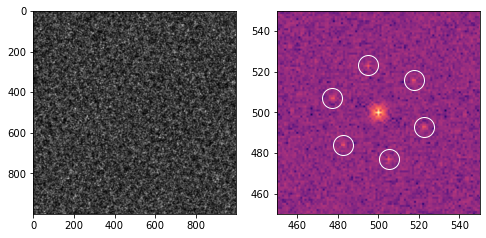

In [8]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,8))

calibrator = FourierSpaceCalibrator('hexagonal', lattice_constant=2.46, max_sampling=.2, min_sampling=.01)
f = np.abs(np.fft.fftshift(windowed_fft(noisy_image))) 
calibrator.calibrate(noisy_image)

spots = calibrator.get_spots()

ax1.imshow(gaussian_filter(noisy_image,2),cmap='gray')
ax2.imshow(f ** .1,cmap='magma')
ax2.plot(*spots.T,'wo', mfc='none', markersize=20)

n = 50
ax2.set_xlim(f.shape[0] // 2 - n, f.shape[0] // 2 + n)
ax2.set_ylim(f.shape[1] // 2 - n, f.shape[1] // 2 + n);

print('true sampling', 0.05, 'detected sampling', calibrator(noisy_image))

### Image series

If a 3d array is given to the calibrator it will be interpreted as an image time series, where the first dimension indexes individual images. The algorithm will average the images in Fourier space and output a single pixel size for the series.

We simulate a series of 40 images with pixel size varying from 0.05 Å to 0.1 Å.

In [9]:
image_series = []
shape = 1024
for sampling in np.linspace(0.05, 0.1, 40):
    atoms = make_graphene((shape * sampling, shape * sampling), rotation=15)
    image = simulate_2d_material(atoms, shape=shape, probe_profile=probe_profile(1.5, 1.4, .5))
    image_series += [np.random.poisson(image*.2).astype(np.float32)]
    
image_series = np.array(image_series)

In [10]:
image_series.shape, calibrator(image_series)

((40, 1024, 1024), 0.08905864721266536)

If we don't want to average over all images in the series we can write a loop and extract subseries to use as input.

In [11]:
n = 3 # number of images to average over

calibrator = FourierSpaceCalibrator(template='hexagonal', lattice_constant=2.46, 
                                    min_sampling=.01, max_sampling=.5)

detected_samplings = []
for i in range(len(image_series) - n + 1):
    
    sub_series = image_series[i:i+n]
    
    detected_samplings.append(calibrator(sub_series))

The calibrator only detects the sampling to within the Fourier space sampling, hence the jaggedness in the plot below.

Text(0.5, 0, 'Image index')

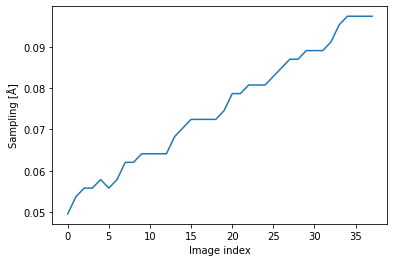

In [12]:
plt.plot(detected_samplings)
plt.ylabel('Sampling [Å]')
plt.xlabel('Image index')

## Graphene Templates

There are two available templates for graphene: `hexagonal` and `2nd-order-hexagonal`.
* `hexagonal` matches only the first order spots, this is *more* robust at high noise, since attempting to match the higher order spots just adds noise.
* `2nd-order-hexagonal` matches the first and second order spots, this is may be more robust for small fields of view (20 Å), since the small Fourier space sampling tends to smear the first order spots. Including 2nd order spots is also more robust for situations with extremely low noise or large amounts of contamination.

If the field of view is small and the noise is high, it may be necessary to detect the scale in real space.

In [13]:
atoms = make_graphene((50,50))
image = simulate_2d_material(atoms, probe_profile(1.5, 1.4, .5), sampling=.05)
noisy_image = np.random.poisson(image * .005).astype(np.float32)

atoms = make_graphene((12,12))
small_fov_image = simulate_2d_material(atoms, probe_profile(1.5, 1.4, .5), sampling=.05)
small_fov_image = np.random.poisson(small_fov_image).astype(np.float32)

0.04663028116637148


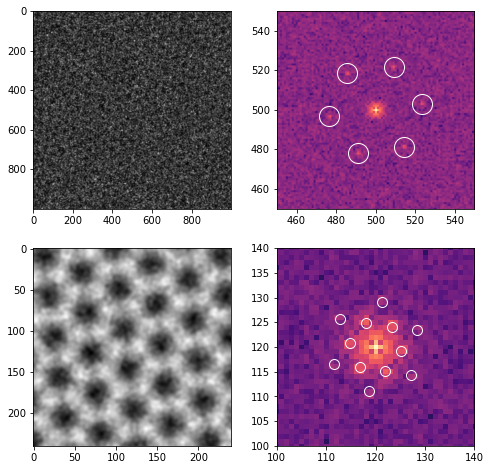

In [16]:
fig,((ax1,ax2),(ax3,ax4)) = plt.subplots(2,2,figsize=(8,8))

cal = FourierSpaceCalibrator('hexagonal', lattice_constant=2.46, max_sampling=.5, min_sampling=.01)
f = np.abs(np.fft.fftshift(windowed_fft(noisy_image)))

cal(noisy_image)

spots = cal.get_spots()

ax1.imshow(gaussian_filter(noisy_image,2),cmap='gray')
ax2.imshow(f ** .1,cmap='magma')
ax2.plot(*spots.T,'wo', mfc='none', markersize=20)

n = 50
ax2.set_xlim(f.shape[0] // 2 - n, f.shape[0] // 2 + n)
ax2.set_ylim(f.shape[1] // 2 - n, f.shape[1] // 2 + n);

cal = FourierSpaceCalibrator('2nd-order-hexagonal', lattice_constant=2.46, max_sampling=.5, min_sampling=.02)
f = np.abs(np.fft.fftshift(windowed_fft(small_fov_image)))

cal(small_fov_image)

spots = cal.get_spots()

ax3.imshow(gaussian_filter(small_fov_image,2),cmap='gray')
ax4.imshow(f ** .1,cmap='magma')
ax4.plot(*spots.T,'wo', mfc='none', markersize=10)

n = 20
ax4.set_xlim(f.shape[0] // 2 - n, f.shape[0] // 2 + n)
ax4.set_ylim(f.shape[1] // 2 - n, f.shape[1] // 2 + n);

print(cal(small_fov_image))

## Tests

### FOV

The calibrator can work down to a FOV of around 8-10 Angstrom. However, a real space algorithm is generally better equipped for dealing with small FOV.

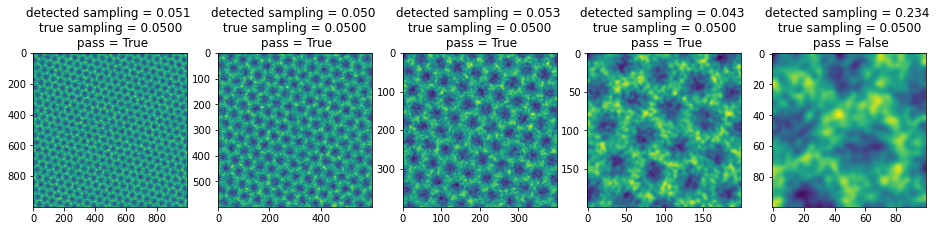

In [17]:
calibrator = FourierSpaceCalibrator('2nd-order-hexagonal', lattice_constant=2.46)
sampling = .05
fig, axes = plt.subplots(1,5, figsize=(16,4))

for i, fov in enumerate([50, 30, 20, 10, 5]):
    atoms = make_graphene((fov,)*2, rotation=15)
    
    image = simulate_2d_material(atoms, sampling=sampling, probe_profile=probe_profile(1.5, 1.4, .5))
    image = np.random.poisson(image*.2).astype(np.float32)
    
    accuracy = hexagonal_pixel_accuracy(image.shape, 2.46)
    detected_sampling = calibrator(image)
    
    axes[i].imshow(gaussian_filter(image, 2))
    axes[i].set_title('detected sampling = {:.3f} \n true sampling = {:.4f} \n pass = {}'.format(calibrator(image), sampling, is_close(detected_sampling, sampling, accuracy)))

### Sampling

The calibrator works across all relevant length scales.

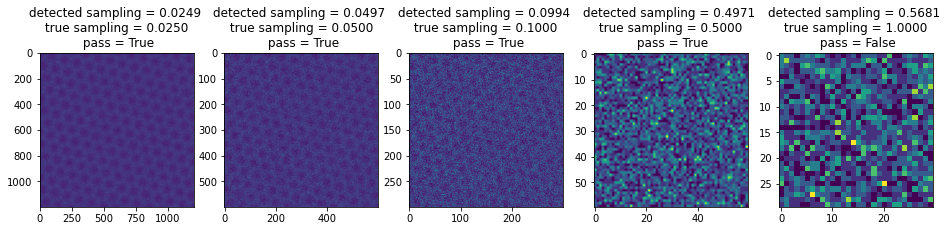

In [18]:
calibrator = FourierSpaceCalibrator('2nd-order-hexagonal', lattice_constant=2.46)

fig, axes = plt.subplots(1,5, figsize=(16,4))

for i, sampling in enumerate((.025, .05, .1, .5, 1)):
    atoms = make_graphene((30,30), rotation=15)
    
    image = simulate_2d_material(atoms, sampling=sampling, probe_profile=probe_profile(1.5, 1.4, .5))
    image = np.random.poisson(image*.1).astype(np.float32)
    
    accuracy = hexagonal_pixel_accuracy(image.shape, 2.46)
    detected_sampling = calibrator(image)
    
    axes[i].imshow(image)
    axes[i].set_title('detected sampling = {:.4f} \n true sampling = {:.4f} \n pass = {}'.format(detected_sampling, sampling, is_close(detected_sampling, sampling, accuracy)))

### Contamination

The algorithm may start to fail when 50 % or mor of the image is contamination. A real space or hybrid algorithm may be better equipped to deal with these situations.

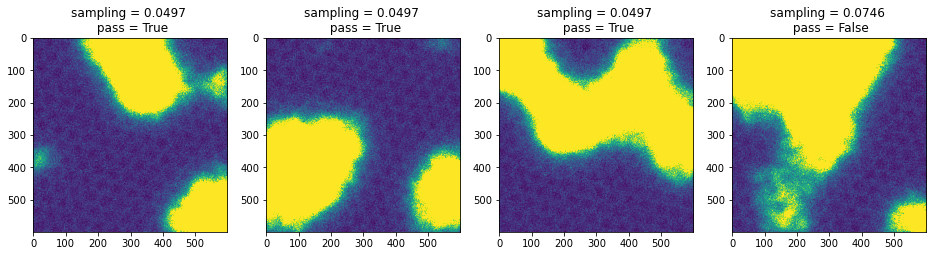

In [21]:
calibrator = FourierSpaceCalibrator('2nd-order-hexagonal', lattice_constant=2.46)
sampling = .05

fig, axes = plt.subplots(1,4, figsize=(16,4))

for i, f in enumerate((.3, .4, .5, .6)):
    atoms = make_graphene((30,30), rotation=15)
    atoms += make_amourphous_contamination((30,30), f, .3, 5)
    
    image = simulate_2d_material(atoms, sampling=.05, probe_profile=probe_profile(1.5, 1.4, .5))
    image = np.random.poisson(image*.05).astype(np.float32)
    
    accuracy = hexagonal_pixel_accuracy(image.shape, 2.46)
    detected_sampling = calibrator(image)
    
    axes[i].imshow(image, vmax=7)
    axes[i].set_title('sampling = {:.4f} \n pass = {}'.format(detected_sampling, is_close(detected_sampling, sampling, accuracy)))